In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import segyio # to read seismic
from pathlib import Path
import random
import tensorflow as tf
import cv2

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose   
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, History
from keras import backend as K
from sklearn.model_selection import train_test_split

#colourmap
from seiscm import seismic

# what is the current directory?
current_dir = os.getcwd()
current_dir

'C:\\Users\\turnera\\OneDrive - RPS Group PLC\\SPEGeohackathon2023'

# importing input training dataset without AGC

In [2]:
pathlist = Path(current_dir).glob('**/*_full.sgy')
all_dataset_seismic = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    #print(path_in_str)
    with segyio.open(path_in_str, 'r', ignore_geometry = True) as segyfile:
        data = segyfile.trace.raw[:]
        all_dataset_seismic.append(data)
        



In [3]:
training_dataset = [all_dataset_seismic[i] for i in [0,1,3,4,5,6,7]]  ## for training dataset
unseen_dataset = all_dataset_seismic[2]

# Importing ground truth training dataset

In [4]:
pathlist = Path(current_dir).glob('**/*_AcousticImpedance.sgy')
trainingtrue_dataset = []
acoustic_impedence_headers = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    #print(path_in_str)
    with segyio.open(path_in_str, 'r') as segyfile:
        data = segyfile.trace.raw[:]
        trainingtrue_dataset.append(data)
        acoustic_impedence_headers.append(segyfile.header[:])

trainingtrue_dataset = [x.T for x in trainingtrue_dataset]

In [5]:
acoustic_impedence_headers[0]

<generator object Header.__getitem__.<locals>.gen at 0x000002B5433B8040>

In [6]:
np.shape(training_dataset[2])

(18327, 5001)

# Aligning ground truth to dataset

In [7]:
# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
training_dataset_clipped = []
training_dataset_clipped.append(training_dataset[0].T[300:1101,15450:20166])
training_dataset_clipped.append(training_dataset[1].T[500:1101,10475:18801])
training_dataset_clipped.append(training_dataset[2].T[500:1101,10470:18251])
training_dataset_clipped.append(training_dataset[3].T[500:1101,7000:13951])
training_dataset_clipped.append(training_dataset[4].T[500:1101,8475:10951])
training_dataset_clipped.append(training_dataset[5].T[500:1101,2800:6801])
training_dataset_clipped.append(training_dataset[6].T[500:1101,4400:7276])

In [8]:
for dataset in training_dataset_clipped:
    print(np.shape(dataset))

(801, 4716)
(601, 8326)
(601, 7781)
(601, 6951)
(601, 2476)
(601, 4001)
(601, 2876)


In [9]:
for dataset in trainingtrue_dataset:
    print(np.shape(dataset))

(801, 4716)
(601, 8326)
(601, 7781)
(601, 6951)
(601, 2476)
(601, 4001)
(601, 2876)


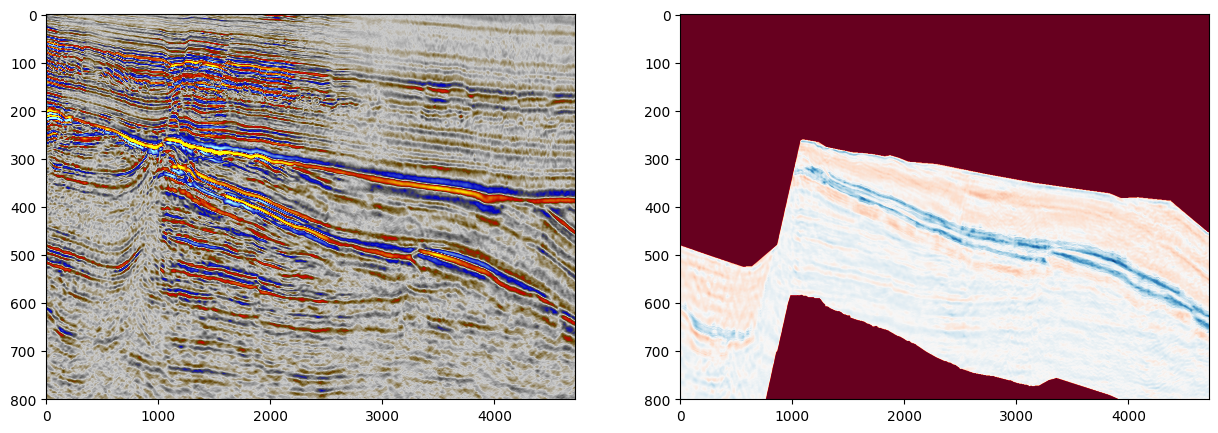

In [10]:
clip_percentile = 99.9
vm = np.percentile(training_dataset_clipped[0], clip_percentile)

plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
plt.imshow(training_dataset_clipped[0]*-1, cmap = seismic(), aspect = 'auto', vmin = -vm, vmax = vm)
plt.subplot(1, 2, 2)
plt.imshow(trainingtrue_dataset[0], cmap = "RdBu", aspect = 'auto')

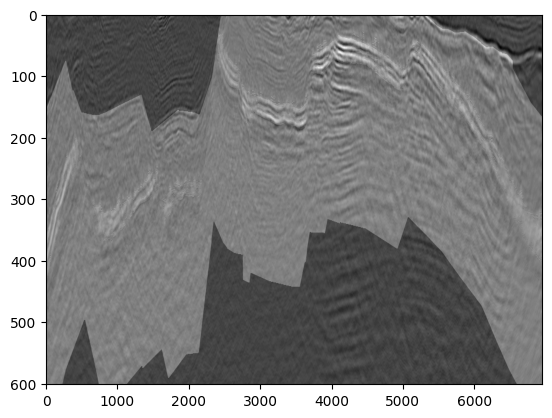

In [11]:
plt.imshow(cv2.addWeighted(training_dataset_clipped[3]*-1, 0.5, trainingtrue_dataset[3], 0.01, 0), cmap='gray', aspect = 'auto')
plt.show()

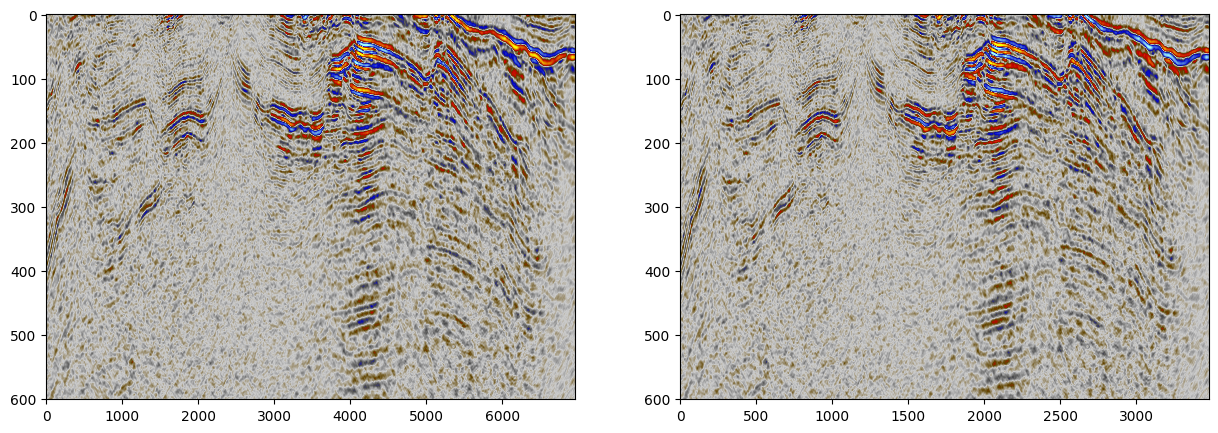

In [12]:
base_y_dims, base_x_dims = np.shape(training_dataset_clipped[3])
rescaled_x_dims = int(base_x_dims * 0.5)
rescaled_dataset = cv2.resize(training_dataset_clipped[3], dsize=(rescaled_x_dims, base_y_dims), interpolation=cv2.INTER_LINEAR)
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
plt.imshow(training_dataset_clipped[3]*-1, cmap = seismic(), aspect = 'auto', vmin = -vm, vmax = vm)
plt.subplot(1, 2, 2)
plt.imshow(rescaled_dataset, cmap = seismic(), aspect = 'auto', vmin = -vm, vmax = vm)

In [13]:
np.shape(training_dataset_clipped[3])

(601, 6951)

# Augmenting dataset

In [14]:
def create_augmented_data(dataset, patch_size, increment, rescale_factors=[1.0], normalise=True):
    output_list = []
    base_y_dims, base_x_dims = np.shape(dataset)
    factor = max(np.max(dataset), -np.min(dataset)) if normalise else 1.0
    for rescale_factor in rescale_factors:
        rescaled_x_dims = int(base_x_dims * rescale_factor)
        rescaled_dataset = cv2.resize(dataset, dsize=(rescaled_x_dims, base_y_dims), interpolation=cv2.INTER_LINEAR)
        for i in range (0, (rescaled_x_dims-patch_size)//increment):
            for j in range (0, (base_y_dims-patch_size)//increment):
                output_list.append(rescaled_dataset[j*increment:j*increment+patch_size, i*increment:i*increment+patch_size]/factor)
                output_list.append(np.fliplr(rescaled_dataset[j*increment:j*increment+patch_size, i*increment:i*increment+patch_size]/factor))

    return output_list
    

In [30]:
patch_size = 256
increment = 64
rescale_factors = [1.0]
augmented_input_data = []
augmented_gt_data = []

for input_data, gt_data in zip(training_dataset_clipped, trainingtrue_dataset):
    augmented_input_data.extend(create_augmented_data(input_data, patch_size, increment, rescale_factors))
    augmented_gt_data.extend(create_augmented_data(gt_data, patch_size, increment, rescale_factors))

In [31]:
len(augmented_input_data)

5894

In [17]:
np.shape(augmented_input_data[967])

(256, 256)

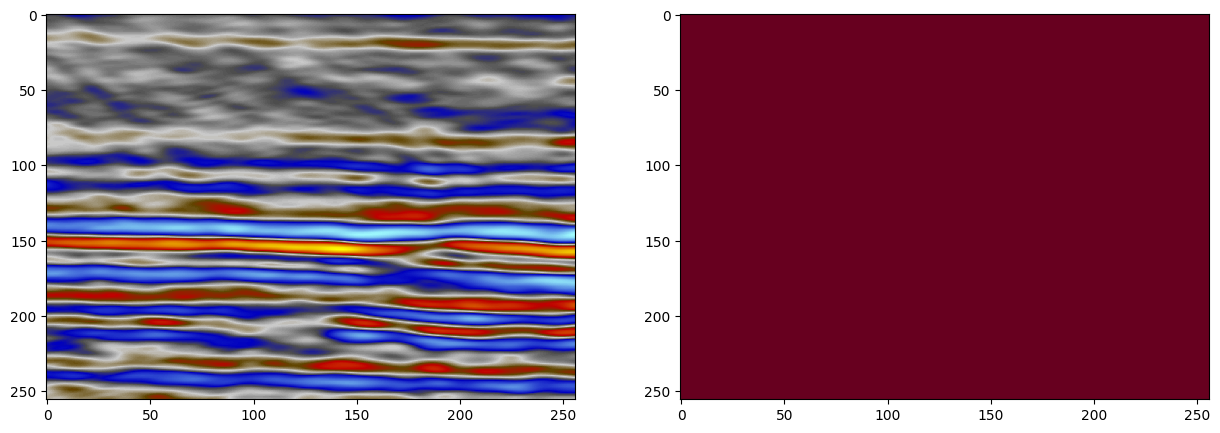

In [32]:
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
plt.imshow(augmented_input_data[800]*-1, cmap = seismic(), aspect = 'auto')
plt.subplot(1, 2, 2)
plt.imshow(augmented_gt_data[800], cmap = "RdBu", aspect = 'auto')

In [33]:
pruned_inputs = []
pruned_gt = []
prune_threshold = 0.1

for input_data, gt_data in zip(augmented_input_data, augmented_gt_data):
    if (np.count_nonzero(gt_data)/np.size(gt_data))>(1-prune_threshold):
        pruned_inputs.append(input_data)
        pruned_gt.append(gt_data)

In [34]:
len(pruned_inputs)

2908

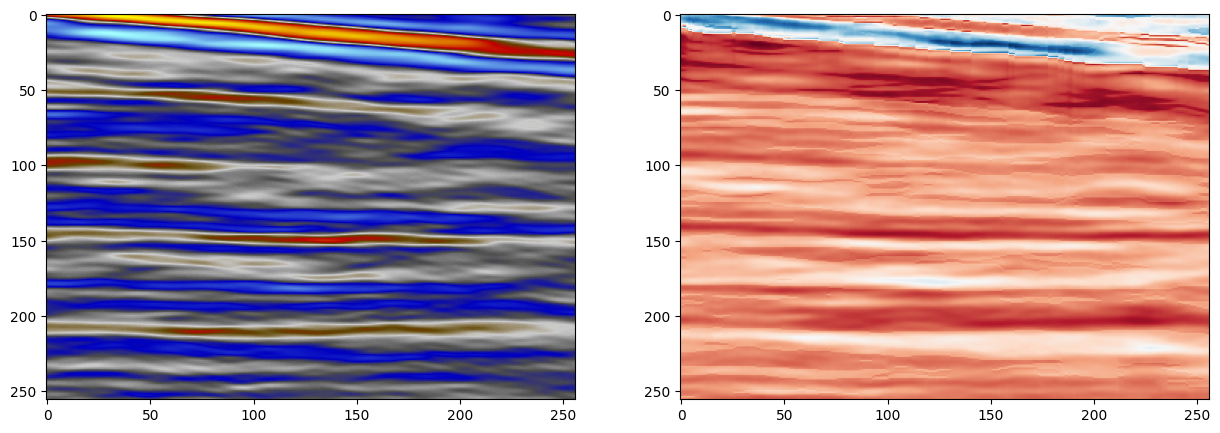

In [40]:
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
plt.imshow(pruned_inputs[100]*-1, cmap = seismic(), aspect = 'auto')
plt.subplot(1, 2, 2)
plt.imshow(pruned_gt[100], cmap = "RdBu", aspect = 'auto')

# Model building

In [22]:
def unet(input_shape, num_channels):
    inputs = Input(shape=(input_shape[0], input_shape[1], num_channels))

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Center
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    # Output layer with linear activation for regression
    output_layer = Conv2D(1, (1, 1), activation='linear')(conv9)

    model = Model(inputs=inputs, outputs=output_layer)

    return model


input_shape = pruned_inputs[0].shape # Change this based on your image size
num_channels = 1  # Set the number of input channels (RGB images have 3 channels)

model = unet(input_shape, num_channels)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [23]:
def MSE_loss_ignore_zero(y_true, y_pred):
    isMask = K.equal(y_true, 0.0)
    #transform to float (0 or 1) and invert
    isMask = K.cast(isMask, dtype=K.floatx())
    isMask = 1 - isMask #now mask values are zero, and others are 1
    loss = np.square(np.subtract(y_true*isMask, y_pred*isMask)).mean()
    return loss

In [25]:
def custom_loss(yTrue,yPred):

    #find which values in yTrue (target) are the mask value
    isMask = K.equal(yTrue, 0.0) #true for all mask values

    #since y is shaped as (batch, length, features), we need all features to be mask values
    #isMask = K.all(isMask, axis=-1) #the entire output vector must be true
        #this second line is only necessary if the output features are more than 1

    #transform to float (0 or 1) and invert
    isMask = K.cast(isMask, dtype=K.floatx())
    isMask = 1 - isMask #now mask values are zero, and others are 1

    #multiply this by the inputs:
       #maybe you might need K.expand_dims(isMask) to add the extra dimension removed by K.all
    yTrue = yTrue * isMask   
    yPred = yPred * isMask

    return someLossFunction(yTrue,yPred)

In [26]:
model.compile(optimizer = Adam(lr = 1e-3), loss = 'MSE', metrics = 'MAE')

In [27]:
inputs = tf.expand_dims(np.concatenate(tf.expand_dims(pruned_inputs,0), axis=0),3) 
ground_truth = tf.expand_dims(np.concatenate(tf.expand_dims(pruned_gt,0), axis=0),3)

In [28]:
print(np.shape(inputs))
print(np.shape(ground_truth))

(508, 256, 256, 1)
(508, 256, 256, 1)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(inputs, ground_truth, test_size=0.2)

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([470,  30,   8, 110,  41,  21, 126, 336, 278, 466,   0, 124, 273,
        50, 233, 224, 310, 471, 418, 198, 189, 159,  16, 397, 201, 479,
       251, 448, 193, 372, 197, 474, 267, 357, 444, 345, 216, 433,  79,
       229, 385,  65,  99, 348,  45, 498, 165,  23, 377, 287,  56, 265,
       330, 333, 347, 217, 499, 130, 432, 380, 425,  72, 496, 180, 483,
       255, 200,   4, 226, 401, 384, 376, 196, 293, 322, 102,  83,  81,
       290, 175, 398, 378, 317, 464, 303, 213, 131,  73, 249,  47, 469,
        76, 500, 170, 428, 286, 101, 494, 108, 176, 239, 199, 452, 210,
       206, 172, 158, 154, 113,  46, 191, 225, 270,  70,  27, 319, 430,
       275, 282,  94,  22, 212, 403, 114,  96, 399, 279,  97,  84,  37,
       321, 353, 409, 308, 405, 340, 359, 241, 214, 400, 194, 419, 246,
       173, 381, 454, 135, 222, 446, 179, 120, 495,   1, 332, 260,  48,
         9, 354, 410, 182,  44,  39, 109, 408,   6, 174, 343, 257, 248,
       431, 211,  54, 440, 480, 115, 374, 335, 316, 118, 315, 121, 148,
       424, 185, 247, 502, 506, 342, 103,   3, 149,  59,   5, 236,  95,
        68,  74, 459, 379,  67,  25, 368,  51, 442, 161,  52, 296, 136,
       491, 268, 280, 298, 404, 362,  88, 360,  14, 455,  57, 162, 105,
       344, 261, 306, 168, 503, 291, 215, 482, 228, 227, 117, 163, 111,
       437,  38, 450, 472, 358, 468, 186, 324, 439, 238, 292, 389, 312,
       145, 434,  69, 395,  24, 497, 415, 351, 318, 334, 449, 383, 259,
       484, 100, 443, 363, 141, 285, 406, 420, 272, 388, 350, 364, 288,
       252, 504, 250, 192, 328,  89, 208,  40,  29, 476, 190, 370, 243,
       453, 256, 458, 262, 478, 394, 209,  61, 301,  17,  42, 181, 127,
       373, 392, 487,  77, 297,  43, 414,  53, 490,  66, 366, 142, 365,
       245, 302, 341, 375, 423, 386, 327,  18, 155, 134, 447,  58, 138,
       463, 263, 295, 153, 129,  64, 221, 264,  98, 112, 104, 202, 254,
       331, 146, 230, 309, 422, 266,  92, 277,  85, 427, 123, 164, 451,
        31, 223, 337,  28, 284, 390, 396, 122, 435, 237,  32, 361, 486,
       157, 107,  60, 421, 220, 462, 294,  34, 413, 417,  11, 271, 473,
       147,  75, 461,  78, 367, 156, 137, 338, 426, 152, 144,  71, 402,
       253, 507,  87, 187, 313, 140, 269, 125, 231, 132, 481, 369, 169,
        63, 371, 234])

In [36]:
history = model.fit(inputs, ground_truth, batch_size = 10, epochs = 2, verbose = 1, shuffle = True, 
                     validation_split = 0.2)

Epoch 1/2
41/41 [==============================] - 1191s 28s/step - loss: 11.0861 - MAE: 0.8254 - val_loss: 0.0165 - val_MAE: 0.0830
Epoch 2/2
41/41 [==============================] - 1197s 29s/step - loss: 0.0123 - MAE: 0.0765 - val_loss: 0.0099 - val_MAE: 0.0707


In [37]:
np.shape(inputs)

TensorShape([508, 256, 256, 1])

In [38]:
pred=model.predict(inputs)

16/16 [==============================] - 366s 23s/step


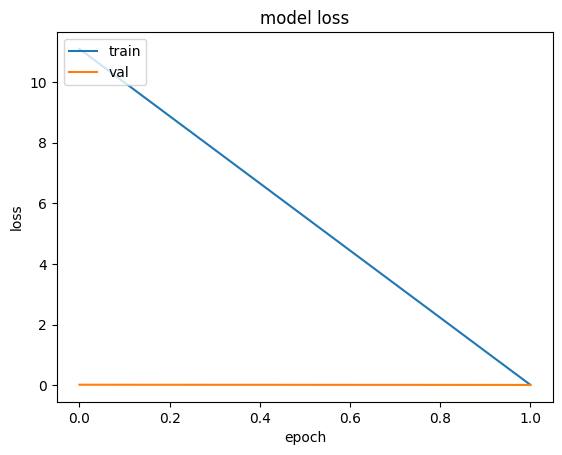

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

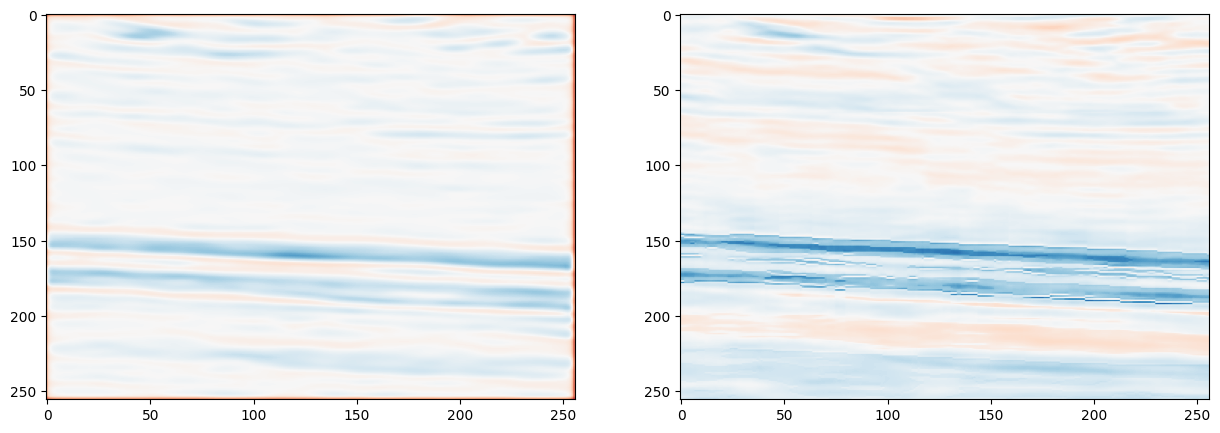

In [39]:
sample=100
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
plt.imshow(pred[sample,:,:,0], cmap = "RdBu", aspect = 'auto', vmin = 0, vmax = 1)
plt.subplot(1, 2, 2)
plt.imshow(ground_truth[sample,:,:,0], cmap = "RdBu", aspect = 'auto', vmin = 0, vmax = 1)

In [ ]:
from keras.models import Model   # https://towardsdatascience.com/medical-images-segmentation-using-keras-7dc3be5a8524
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, History
from keras import backend as K
K.set_image_data_format('channels_last')

def U_Net():
    inputs = Input((None, None, 1))
    conv1 = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(inputs)
    conv1 = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size = (2,2))(conv1)
    
    conv2 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size = (2,2))(conv2)
    
    conv3 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size = (2,2))(conv3)
    
    conv4 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(conv4)
    pool4 = MaxPooling2D(pool_size = (2,2))(conv4)
    
    conv5 = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2,2), strides = (2,2), padding = 'same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(up6)
    conv6 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(up7)
    conv7 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(conv7)
    
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(up8)
    conv8 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(up9)
    conv9 = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(conv9)
    
    conv10 = Conv2D(1, (1,1), activation = 'sigmoid')(conv9)
    
    model = Model(inputs = [inputs], outputs = [conv10])
    model.compile(optimizer = Adam(lr = 1e-3), loss = 'MSE', metrics = 'MAE')
    return model

In [36]:
model1 = U_Net()
history = model1.fit(training_dataset, trainingtrue_dataset, batch_size = 10, epochs = 2, verbose = 1, shuffle = True, 
                     validation_split = 0.2)

ValueError: Data cardinality is ambiguous:
  x sizes: 624, 600, 600, 590, 600, 600, 600
  y sizes: 624, 624, 624, 624, 624, 624, 624
Make sure all arrays contain the same number of samples.

In [41]:
    #Saving our predictions in the directory 'preds'
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('Model dice coeff')
    plt.ylabel('Dice coeff')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

KeyError: 'dice_coef'

# Loading horizon data

In [69]:
from segysak.segy import (
    segy_loader,
    get_segy_texthead,
    segy_header_scan,
    segy_header_scrape,
    well_known_byte_locs,
)
import pathlib
import fiona

In [72]:
hrz_file = pathlib.Path(current_dir + r"\Input_datasets\Horizons\1-nu_dgmdeep5_asc\Edge around NU_nodata_DGM50_RD.shp")
import geopandas as gpd
shapefile = gpd.read_file(hrz_file)
shapefile.head()

,geometry
0,"LINESTRING Z (262832.281 468835.875 0.000, 262..."


# Loading wells dataset

# Building model

# importing input unseen dataset

# outputing the prediction for unseen dataset